<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [160]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [161]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [162]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [163]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [164]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 1
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [165]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[-1.6725762e-01 -3.1162581e-01 -2.1327846e+00 -5.3098708e-01
  -8.9275002e-02]
 [ 4.0995377e-01 -8.3897609e-01 -6.6018647e-01 -6.1645728e-01
  -4.2871732e-01]
 [ 7.1839142e-01 -1.5507836e+00 -1.2814782e+00  4.8285675e-01
   1.4164952e+00]
 [-1.7379222e+00  9.0540695e-01  3.1791076e-01 -5.0518852e-01
   2.4909838e-04]
 [-6.5142220e-01 -2.1446601e-01  2.5114097e-02 -6.6966850e-01
  -4.8748511e-01]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


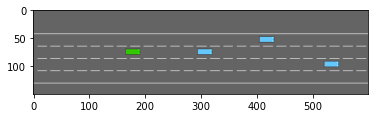

[[ 1.          0.89241105  0.25        0.3125      0.        ]
 [ 1.          0.1168308   0.         -0.02055391  0.        ]
 [ 1.          0.2181603  -0.25       -0.03165723  0.        ]
 [ 1.          0.32349655  0.25       -0.02262461  0.        ]
 [ 1.          0.43191004  0.25       -0.0289528   0.        ]]

Acción: LANE_RIGHT -> recommpensa: 0.8444444444444444
Nuevo estado:


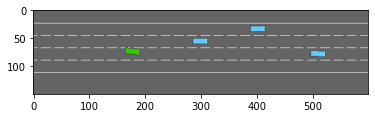

[[ 1.          1.          0.4582173   0.31063917  0.03405233]
 [ 1.          0.1094271  -0.20821731 -0.0208772  -0.03405233]
 [ 1.          0.20339373 -0.4582173  -0.04776418 -0.03405233]
 [ 1.          0.30226108  0.05169223 -0.08356342 -0.01963163]
 [ 1.          0.4202541   0.00931765 -0.03636873 -0.06803605]]

Acción: LANE_LEFT -> recommpensa: 0.8222222222222223
Nuevo estado:


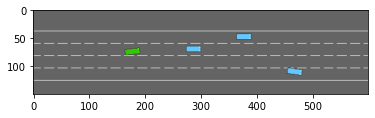

[[ 1.          1.          0.30546886  0.31062725 -0.0341609 ]
 [ 1.          0.09830907 -0.05546886 -0.03921599  0.0341609 ]
 [ 1.          0.18015985 -0.30546886 -0.06870349  0.0341609 ]
 [ 1.          0.26452884  0.41141304 -0.08649998  0.06480712]
 [ 1.          0.4052886   0.15916988 -0.03801402  0.04706785]]

Acción: SLOWER -> recommpensa: 0.7116739868390409
Nuevo estado:


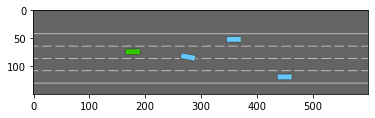

[[ 1.          1.          0.24186051  0.26067236 -0.00206264]
 [ 1.          0.09066679  0.12296911 -0.00884151  0.05096713]
 [ 1.          0.16450247 -0.24186051 -0.01939754  0.00206264]
 [ 1.          0.2465255   0.5195273  -0.01468692  0.0021782 ]
 [ 1.          0.40192753  0.25956795  0.01109435  0.00478825]]

Acción: IDLE -> recommpensa: 0.6927825940533742
Nuevo estado:


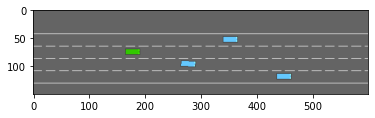

[[ 1.          1.          0.24745536  0.25182134  0.00139205]
 [ 1.          0.09049354  0.257132    0.00576749  0.00937243]
 [ 1.          0.15888053 -0.24745536 -0.01051579 -0.00139205]
 [ 1.          0.24552074  0.5044572   0.00772908 -0.00294606]
 [ 1.          0.39876688  0.0050583  -0.04188473 -0.00269817]]

Acción: IDLE -> recommpensa: 0.6895542772906024
Nuevo estado:


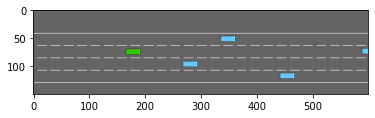

[[ 1.0000000e+00  1.0000000e+00  2.5033298e-01  2.5031185e-01
   1.3346794e-04]
 [ 1.0000000e+00  9.3596242e-02  2.5648269e-01  9.2102997e-03
  -2.3810903e-03]
 [ 1.0000000e+00  1.5508643e-01 -2.5033298e-01 -8.7423548e-03
  -1.3346794e-04]
 [ 1.0000000e+00  2.5092632e-01  4.9909204e-01  1.9530758e-02
  -1.5160131e-04]
 [ 1.0000000e+00  3.8476586e-01 -5.8826408e-04 -2.8327573e-02
  -2.9726437e-04]]

Acción: LANE_LEFT -> recommpensa: 0.6667803737159762
Nuevo estado:


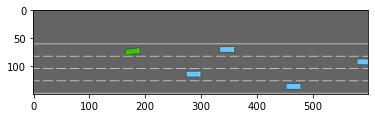

[[ 1.          1.          0.0414221   0.24784411 -0.03316541]
 [ 1.          0.09901629  0.45846233  0.01278741  0.03259399]
 [ 1.          0.1531537  -0.0414221  -0.00601236  0.03316541]
 [ 1.          0.26172692  0.708472    0.02901193  0.03324608]
 [ 1.          0.37661618  0.20845051 -0.01748758  0.03322143]]

Acción: LANE_LEFT -> recommpensa: 0.6666860978635878
Nuevo estado:


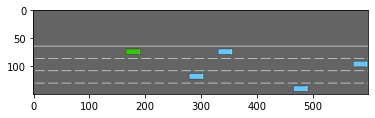

[[ 1.0000000e+00  1.0000000e+00 -1.1251933e-02  2.5000831e-01
  -6.2578486e-04]
 [ 1.0000000e+00  1.0355529e-01  5.1091033e-01  1.1427625e-02
   7.2851626e-04]
 [ 1.0000000e+00  1.5005834e-01  1.1251933e-02 -8.0106771e-03
   6.2578486e-04]
 [ 1.0000000e+00  2.7290052e-01  7.6128107e-01  2.8394157e-02
   6.2720437e-04]
 [ 1.0000000e+00  3.7002841e-01  2.6126051e-01 -1.3985602e-02
   6.3490076e-04]]

Acción: LANE_RIGHT -> recommpensa: 0.6888922094518275
Nuevo estado:


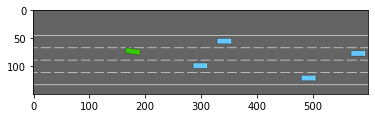

[[ 1.          1.          0.20665236  0.24758756  0.03465803]
 [ 1.          0.10988507  0.293348    0.01481645 -0.03462792]
 [ 1.          0.14844927 -0.20665236 -0.00553666 -0.03465803]
 [ 1.          0.28609055  0.5433534   0.03209167 -0.0346622 ]
 [ 1.          0.36677483  0.04335396 -0.00776868 -0.03466046]]

Acción: SLOWER -> recommpensa: 0.6888894563340274
Nuevo estado:


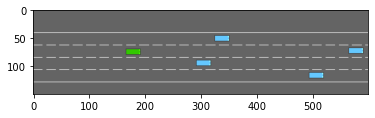

[[ 1.0000000e+00  1.0000000e+00  2.6175123e-01  2.4999939e-01
   6.6199468e-04]
 [ 1.0000000e+00  1.1519495e-01  2.3826587e-01  1.3398915e-02
  -6.6666753e-04]
 [ 1.0000000e+00  1.4542609e-01 -2.6175123e-01 -7.9885116e-03
  -6.6199468e-04]
 [ 1.0000000e+00  2.9830748e-01  4.8824731e-01  3.0608786e-02
  -6.6210196e-04]
 [ 1.0000000e+00  3.6337346e-01 -1.1751487e-02 -7.6262420e-03
  -6.6248659e-04]]

Acción: IDLE -> recommpensa: 0.6888889858585868
Nuevo estado:


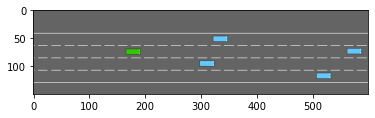

[[ 1.          1.          0.25235093  0.2499945  -0.00166385]
 [ 1.          0.12073253  0.24764931  0.01432636  0.00166228]
 [ 1.          0.14221573 -0.25235093 -0.00808658  0.00166385]
 [ 1.          0.31068262  0.49764878  0.03126051  0.00166407]
 [ 1.          0.36067292 -0.00235123 -0.00587517  0.00166396]]

Acción: LANE_RIGHT -> recommpensa: 0.7111111276820915
Nuevo estado:


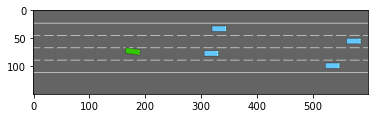

[[ 1.          1.          0.45823285  0.24780849  0.03302969]
 [ 1.          0.12802814  0.0417663   0.01733345 -0.03302947]
 [ 1.          0.14036451 -0.45823285 -0.00603714 -0.03302969]
 [ 1.          0.32468173  0.29176724  0.03387813 -0.03302968]
 [ 1.          0.35997325 -0.20823283 -0.00246614 -0.03302966]]

Acción: LANE_RIGHT -> recommpensa: 0.733333336165119
Nuevo estado:


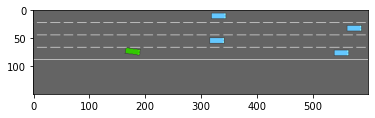

[[ 1.          1.          0.7195347   0.2476881   0.03392059]
 [ 1.          0.1365295  -0.21953472  0.01815158 -0.03392051]
 [ 1.          0.13935558 -0.7195347  -0.00606337 -0.03392059]
 [ 1.          0.33972198  0.03046531  0.03427374 -0.0339206 ]
 [ 1.          0.36059374 -0.4695347  -0.00146362 -0.0339206 ]]

Acción: LANE_LEFT -> recommpensa: 0.71111111159503
Nuevo estado:


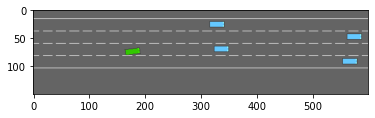

[[ 1.0000000e+00  1.0000000e+00  5.5418587e-01  2.4769141e-01
  -3.3896420e-02]
 [ 1.0000000e+00  1.3697058e-01 -5.5418587e-01 -6.2062466e-03
   3.3896420e-02]
 [ 1.0000000e+00  1.4396735e-01 -5.4185838e-02  1.8718699e-02
   3.3896413e-02]
 [ 1.0000000e+00  3.5353225e-01  1.9581412e-01  3.4436297e-02
   3.3896420e-02]
 [ 1.0000000e+00  3.6020553e-01 -3.0418587e-01 -7.9579401e-04
   3.3896420e-02]]

Acción: SLOWER -> recommpensa: 0.7111111111938072
Nuevo estado:


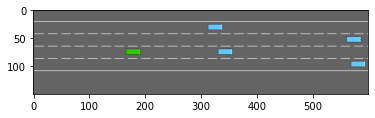

[[ 1.          1.          0.4905009   0.24999014 -0.00222003]
 [ 1.          0.13373242 -0.4905009  -0.00862625  0.00222003]
 [ 1.          0.15081276  0.0094991   0.01688749  0.00222003]
 [ 1.          0.359262   -0.24050091 -0.00253357  0.00222003]
 [ 1.          0.36659357  0.2594991   0.03222905  0.00222003]]

Acción: IDLE -> recommpensa: 0.711111111125243
Nuevo estado:


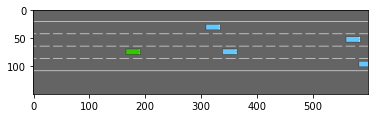

[[ 1.          1.          0.49717334  0.24999492  0.00159341]
 [ 1.          0.13026093 -0.49717334 -0.00872731 -0.00159341]
 [ 1.          0.15764073  0.00282667  0.01727335 -0.00159341]
 [ 1.          0.3583435  -0.24717332 -0.00202251 -0.00159341]
 [ 1.          0.37949222  0.25282666  0.03226617 -0.00159341]]

Acción: LANE_LEFT -> recommpensa: 0.6888888888913037
Nuevo estado:


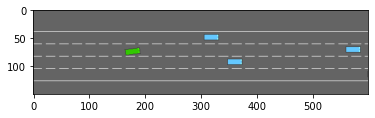

[[ 1.0000000e+00  1.0000000e+00  2.9165578e-01  2.4781807e-01
  -3.2957673e-02]
 [ 1.0000000e+00  1.2815967e-01 -2.9165578e-01 -6.6183996e-03
   3.2957673e-02]
 [ 1.0000000e+00  1.6601734e-01  2.0834421e-01  1.9784102e-02
   3.2957673e-02]
 [ 1.0000000e+00  3.5903218e-01 -4.1655790e-02  6.5967807e-04
   3.2957673e-02]
 [ 1.0000000e+00  3.9380458e-01  4.5834422e-01  3.4452241e-02
   3.2957673e-02]]

Acción: LANE_LEFT -> recommpensa: 0.6666666666670794
Nuevo estado:


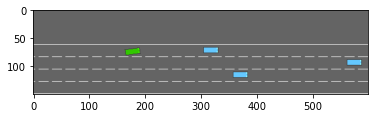

[[ 1.          1.          0.03048577  0.24768871 -0.03391613]
 [ 1.          0.12693873 -0.03048577 -0.00652767  0.03391613]
 [ 1.          0.17542115  0.46951422  0.0202044   0.03391613]
 [ 1.          0.36082545  0.21951422  0.00129812  0.03391613]
 [ 1.          0.40901837  0.71951425  0.03456936  0.03391613]]

Acción: FASTER -> recommpensa: 0.7772149020499185
Nuevo estado:


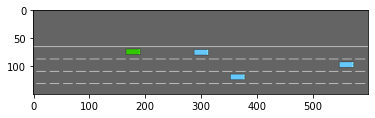

[[ 1.          1.         -0.01710779  0.30181575  0.00149994]
 [ 1.          0.11096974  0.01710779 -0.06066453 -0.00149994]
 [ 1.          0.17019673  0.5171078  -0.03366572 -0.00149994]
 [ 1.          0.3480856   0.26710778 -0.05231323 -0.00149994]
 [ 1.          0.4094864   0.7671078  -0.01958407 -0.00149994]]

Acción: LANE_LEFT -> recommpensa: 0.796106294835527
Nuevo estado:


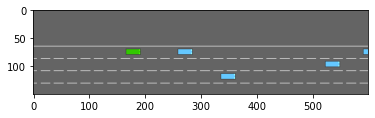

[[ 1.          1.         -0.0019084   0.31066784  0.00208231]
 [ 1.          0.08456412  0.0019084  -0.06949912 -0.00208231]
 [ 1.          0.15463176  0.5019084  -0.04228923 -0.00208231]
 [ 1.          0.32511508  0.2519084  -0.06064553 -0.00208231]
 [ 1.          0.38699442  0.0019084  -0.06996448 -0.00208231]]

Acción: LANE_RIGHT -> recommpensa: 0.8215568338205106
Nuevo estado:


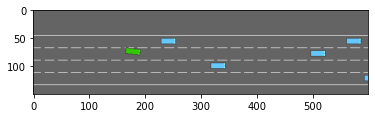

[[ 1.          1.          0.20933196  0.31033543  0.03396072]
 [ 1.          0.05759587 -0.20933196 -0.06912394 -0.03396072]
 [ 1.          0.13857913  0.29066804 -0.04175295 -0.03396072]
 [ 1.          0.30177817  0.04066804 -0.05979351 -0.03396072]
 [ 1.          0.3599051  -0.20933196 -0.06924796 -0.03396072]]

Acción: LANE_RIGHT -> recommpensa: 0.8443307373951351
Nuevo estado:


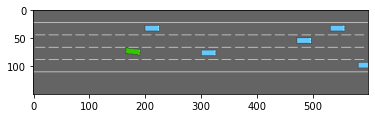

[[ 1.          1.          0.47207212  0.31060869  0.03384056]
 [ 1.          0.03100324 -0.47207212 -0.06933149 -0.03384056]
 [ 1.          0.12295794  0.02792789 -0.04184471 -0.03384056]
 [ 1.          0.27900252 -0.22207211 -0.05955163 -0.03384056]
 [ 1.          0.33332062 -0.47207212 -0.06915255 -0.03384056]]

Acción: SLOWER -> recommpensa: 0.7338767778643422
Nuevo estado:


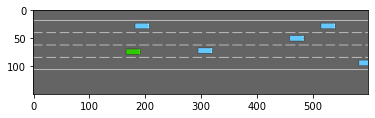

[[ 1.          1.          0.513253    0.26066682 -0.00154731]
 [ 1.          0.01520503 -0.513253   -0.01930337  0.00154731]
 [ 1.          0.11816967 -0.01325299  0.00825799  0.00154731]
 [ 1.          0.2671958  -0.263253   -0.00910264  0.00154731]
 [ 1.          0.31764513 -0.513253   -0.01885632  0.00154731]]

Acción: FASTER -> recommpensa: 0.8255497310958391
Nuevo estado:


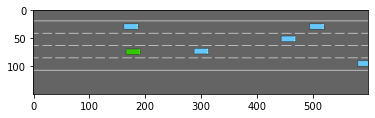

[[ 1.          1.          0.50100124  0.30363914 -0.0015534 ]
 [ 1.         -0.00291305 -0.50100124 -0.06217131  0.0015534 ]
 [ 1.          0.11108423 -0.00100123 -0.03457292  0.0015534 ]
 [ 1.          0.25323215 -0.25100124 -0.05157847  0.0015534 ]
 [ 1.          0.29975104 -0.50100124 -0.06148768  0.0015534 ]]

Acción: IDLE -> recommpensa: 0.8412155602365342
Nuevo estado:


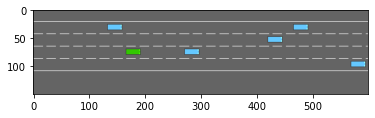

[[ 1.0000000e+00  1.0000000e+00  4.9920827e-01  3.1098643e-01
   1.2964883e-04]
 [ 1.0000000e+00 -2.9541358e-02 -4.9920827e-01 -6.9398381e-02
  -1.2964883e-04]
 [ 1.0000000e+00  9.5496893e-02  7.9173909e-04 -4.1797198e-02
  -1.2964883e-04]
 [ 1.0000000e+00  2.3090981e-01 -2.4920826e-01 -5.8441728e-02
  -1.2964883e-04]
 [ 1.0000000e+00  2.7343592e-01 -4.9920827e-01 -6.8506636e-02
  -1.2964883e-04]]

Acción: LANE_LEFT -> recommpensa: 0.8216704439001203
Nuevo estado:


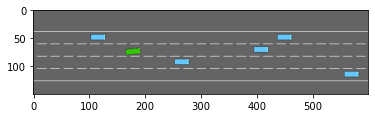

[[ 1.          1.          0.29158998  0.3103882  -0.03396785]
 [ 1.          0.07964996  0.20841002 -0.04109346  0.03396785]
 [ 1.          0.20847309 -0.04158998 -0.05737305  0.03396785]
 [ 1.          0.24694441 -0.29158998 -0.06759196  0.03396785]
 [ 1.          0.35611078  0.45841002 -0.02850235  0.03396785]]

Acción: FASTER -> recommpensa: 0.9326761651820344
Nuevo estado:


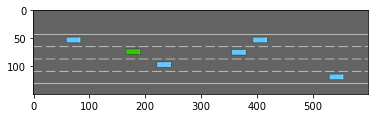

[[ 1.0000000e+00  1.0000000e+00  2.3300748e-01  3.6427477e-01
   6.0643366e-04]
 [ 1.0000000e+00  5.0013769e-02  2.6699254e-01 -9.4891213e-02
  -6.0643366e-04]
 [ 1.0000000e+00  1.7239359e-01  1.6992526e-02 -1.1080334e-01
  -6.0643366e-04]
 [ 1.0000000e+00  2.0674904e-01 -2.3300748e-01 -1.2117329e-01
  -6.0643366e-04]
 [ 1.0000000e+00  3.3148256e-01  5.1699251e-01 -8.2450248e-02
  -6.0643366e-04]]

Acción: SLOWER -> recommpensa: 0.841097501542121
Nuevo estado:


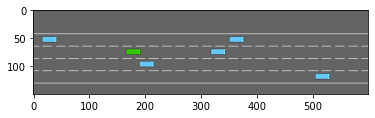

[[ 1.          1.          0.24719827  0.3213402   0.0022099 ]
 [ 1.          0.02248364  0.25280172 -0.05188381 -0.0022099 ]
 [ 1.          0.13856745  0.00280173 -0.06742699 -0.0022099 ]
 [ 1.          0.1687473  -0.24719827 -0.07794412 -0.0022099 ]
 [ 1.          0.3089029   0.5028017  -0.03957934 -0.0022099 ]]

Acción: LANE_RIGHT -> recommpensa: 0.04444444444444443
Nuevo estado:


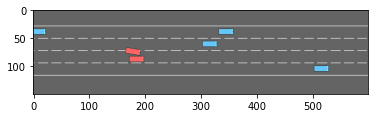

[[ 1.          1.          0.40432745  0.192404    0.03126513]
 [ 1.          0.00616171  0.1492523  -0.02613996 -0.03126513]
 [ 1.          0.12511393 -0.15432745  0.06193641 -0.03126513]
 [ 1.          0.15106013 -0.40432745  0.05127655 -0.03126513]
 [ 1.          0.30649596  0.34567255  0.08929081 -0.03126513]]
Episodio terminado después de 28 pasos y la recompensa fue 20.37388739375989


In [166]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de mejorado

In [167]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

In [207]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (25,)))  # acción del cálculo de Q para esta acción
#             print(state)
#             print(qvals)
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
#             print("*******************")
#             print("ACTUALIZCION")
#             print(state)
            state = np.array([np.ravel(s) for s in state])
#             print(state)
#             print("*******************")
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

In [217]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_position = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.update_position.append(self.state0[0]) # Guardamos la posición final de cada episodio
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
#         print(states)
#         print("*******************")
#         print(actions)
#         print("*******************")
#         print(actions_vals)
#         print("*******************")
#         print(self.main_network.get_qvals(states))
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

In [218]:
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 32       # Tamaño del batch
MAX_EPISODES = 1500   # Número de episodios
BURN_IN = 100        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.99          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [ ]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-217-abf80ff9db09>:145: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 1031 Mean Rewards 24.56 Epsilon 0.01		118606165716			

In [ ]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

In [ ]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))